In [2]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from mcf.data_types.point import Point

In [3]:
class KalmanState:
    def __init__(self, time_step: int=1):
        self.predicted_position = Point(0,0)
        self.predicted_velocity = Point(0,0)
        self.measured_position = Point(0,0)
        self.measured_velocity = Point(0,0)
        self.position = Point(0,0)
        self.velocity = Point(0,0)

        self.process_covariance = 0
        self.measurement_covariance = 0
        
        self.covariance = np.array([[]]) # covariance matrix
        self.observation = np.array([[1, 0, 0, 0],
                                     [0, 1, 0, 0]]) # observation matrix
        
        self.dt = time_step
        
        self.state_transition = np.array([[1, 0, self.dt, 0],
                                     [0, 1, 0, self.dt],
                                     [0, 0, 1, 0 ],
                                     [0, 0, 0, 1 ]])

        self.input_transition = np.array([[0],
                                    [0],
                                    [0],
                                    [0]])

    def getCurrent(self):
        return np.array([[self.position.x, self.position.y, self.velocity.x, self.velocity.y]]).T

    def getPrediction(self):
        return np.array([[self.predicted_position.x, self.predicted_position.y, self.predicted_velocity.x, self.predicted_velocity.y]]).T
    
    def getMeasurement(self):
        return np.array([[self.measured_position.x, self.measured_position.y, self.measured_velocity.x, self.measured_velocity.y]]).T
    

def run_kalman(state: KalmanState):
    _predict_state(state)
    _predict_covariance(state)
    _kalman_filter(state)

def _predict_state(state: KalmanState) -> np.array:
    ps = state.state_transition @ state.getCurrent()
    state.predicted_position = Point(ps[0][0], ps[1][0])
    state.predicted_velocity = Point(ps[2][0], ps[3][0])

def _predict_covariance(state: KalmanState) -> np.array:
    if state.covariance.size == 0:
        state.covariance = state.process_covariance
    state.covariance = state.state_transition @ state.covariance @ state.state_transition.T + state.process_covariance

def _kalman_filter(state: KalmanState):
    # kalman gain
    K = state.covariance @ state.observation.T @ np.linalg.inv(state.observation @ state.covariance @ state.observation.T + state.measurement_covariance)

    # kalman update
    s_t = state.getPrediction() + K @ (state.observation @ state.getMeasurement() - state.observation @ state.getPrediction())
    state.position = Point(s_t[0][0], s_t[1][0])
    state.velocity = Point(s_t[2][0], s_t[3][0])
    state.covariance = (np.eye(4) - K @ state.observation) @ state.covariance

    

# Simulation

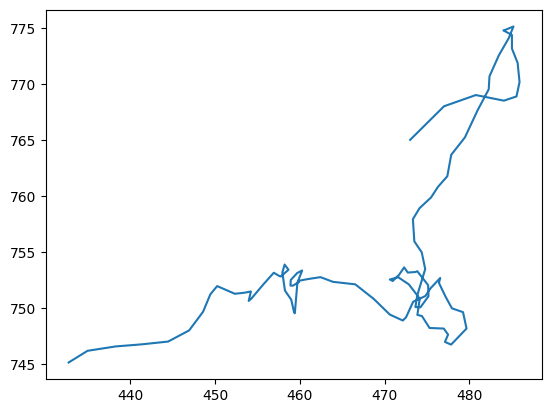

In [4]:
class SimulatorState:
    def __init__(self):
        self.x = np.random.randint(0,1000)
        self.y = np.random.randint(0,1000)
        self.vx = np.random.randint(0,10)-5
        self.vy = np.random.randint(0,10)-5

    def set(self, x, y, vx, vy):
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy
    
    def __str__(self):
        return f"({self.x}, {self.y}, {self.vx}, {self.vy})"

    def __add__(self, other):
        new_state = SimulatorState()
        new_state.x = self.x + other.x
        new_state.y = self.y + other.y
        new_state.vx = self.vx + other.vx
        new_state.vy = self.vy + other.vy
        return new_state

    def np(self):
        return np.array([[self.x, self.y, self.vx, self.vy]]).T

true_state = SimulatorState() # state vector (position, velocity)
position_variance = 1 # measurement variance
velocity_variance = 0.0001
dt = 1

true_position_x = [true_state.x]
true_position_y = [true_state.y]
true_velocity_x = [true_state.vx]
true_velocity_y = [true_state.vy]

for _ in range(100):

    true_state.x = true_state.x + dt*true_state.vx
    true_state.y = true_state.y + dt*true_state.vy
    true_state.vx = 0.75*true_state.vx + 0.25*(np.random.randint(0, 10)-5)
    true_state.vy = 0.75*true_state.vy + 0.25*(np.random.randint(0, 10)-5)

    true_position_x.append(true_state.x)
    true_position_y.append(true_state.y)
    true_velocity_x.append(true_state.vx)
    true_velocity_y.append(true_state.vy)

plt.plot(true_position_x, true_position_y, label='true position')

def measure(idx: int) -> SimulatorState:
    _state = SimulatorState()
    _state.x = true_position_x[idx] + np.random.normal(0, position_variance)
    _state.y = true_position_y[idx] + np.random.normal(0, position_variance)
    _state.vx = true_velocity_x[idx] + np.random.normal(0, velocity_variance)
    _state.vy = true_velocity_y[idx] + np.random.normal(0, velocity_variance)
    return _state

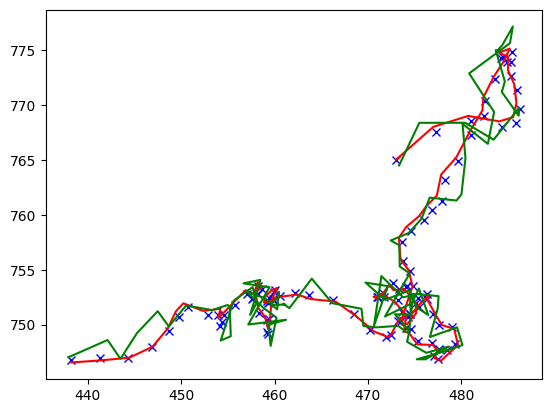

In [6]:
dt = 1 # time step
simulator = SimulatorState()   # initial state
simulator.set(true_position_x[0], true_position_y[0], true_velocity_x[0], true_velocity_y[0])

measured_state = measure(0)
measured_position_x = [measured_state.x]
measured_position_y = [measured_state.y]
tracked_position_x = [simulator.x]
tracked_position_y = [simulator.y]

_state = KalmanState()
_state.position = Point(measured_state.x, measured_state.y)

N = 99
for idx in range(0, N):

    # setup last known state
    _state.position = _state.position # this will be input
    _state.velocity = Point(measured_state.vx, measured_state.vy)

    # variance of position
    measurement_variance = position_variance # measurement variance
    _state.measurement_covariance = measurement_variance * np.eye(2)

    # variance of velocity
    process_variance = velocity_variance # process variance
    _state.process_covariance = process_variance * dt * np.eye(4)

    # measure the next state
    measured_state = measure(idx+1)
    _state.measured_position = Point(measured_state.x, measured_state.y)
    _state.measured_velocity = Point(measured_state.vx, measured_state.vy)

    run_kalman(_state)

    # For plotting
    tracked_position_x.append(_state.position.x)
    tracked_position_y.append(_state.position.y)
    measured_position_x.append(_state.measured_position.x)
    measured_position_y.append(_state.measured_position.y)

plt.plot(tracked_position_x[0:N], tracked_position_y[0:N], 'bx')
plt.plot(true_position_x[0:N], true_position_y[0:N], 'r')
plt.plot(measured_position_x[0:N], measured_position_y[0:N], 'g')
